In [1]:
model_name = "bigscience/bloomz-560m"
#model_name="bigscience/bloom-1b1"
# NUM_VIRTUAL_TOKENS = 4
NUM_EPOCHS = 1

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6, 7"

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    trust_remote_code=True
)

/home/xzrderek/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
for param in model.parameters():
    param.requires_grad = False

In [18]:
model

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

In [19]:
for param in model.transformer.h[-1].parameters():
    param.requires_grad = True

In [29]:
from datasets import load_dataset

dataset_sentences = load_dataset('csv', data_files='data/spongebob_lines.csv')

data_sentences = dataset_sentences.map(lambda samples: tokenizer(samples["Lines"]), batched=True)
data_sentences = data_sentences['train'].train_test_split(test_size=0.2)

train_sample_sentences = data_sentences["train"]
test_sample_sentences = data_sentences["test"]
# train_sample_sentences = train_sample_sentences.remove_columns(['author', 'tags'])
display(train_sample_sentences)

Dataset({
    features: ['Lines', 'input_ids', 'attention_mask'],
    num_rows: 10273
})

# Change Hyperparameters Here

In [30]:
from transformers import TrainingArguments
def create_training_arguments(learning_rate=0.0035, epochs=6):
    training_args = TrainingArguments(
        output_dir="outputs",
        # use_cpu=True, # This is necessary for CPU clusters.
        auto_find_batch_size=True, # Find a suitable batch size that will fit into memory automatically
        learning_rate= learning_rate, # Higher learning rate than full fine-tuning
        logging_steps=1,
        max_steps=50,
        num_train_epochs=epochs
    )
    return training_args

In [31]:
training_args_sentences = create_training_arguments(0.003, NUM_EPOCHS)

In [32]:
from transformers import Trainer, DataCollatorForLanguageModeling
def create_trainer(model, training_args, train_dataset):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset, 
        data_collator=DataCollatorForLanguageModeling(tokenizer, mlm=False) 
    )
    return trainer

In [33]:
trainer_sentences = create_trainer(model, training_args_sentences, train_sample_sentences)
trainer_sentences.train()

test_sentences = create_trainer(model, training_args_sentences, test_sample_sentences)
test_sentences.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
1,12.707500
2,12.184500
3,9.062500
4,8.050400
5,8.334400
6,7.475700
7,6.551800
8,7.208300
9,6.644100
10,6.088400


Step,Training Loss
1,5.610400
2,6.439400
3,5.378500
4,5.579900
5,5.969900
6,4.895800
7,5.728400
8,5.203900
9,5.834200
10,6.120600


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss
1,5.786200
2,7.690600
3,7.480700
4,7.228800
5,6.743800
6,6.499800
7,6.071500
8,6.288700
9,6.247000
10,6.184000


TrainOutput(global_step=50, training_loss=5.597365169525147, metrics={'train_runtime': 30.7099, 'train_samples_per_second': 26.05, 'train_steps_per_second': 1.628, 'total_flos': 79781734514688.0, 'train_loss': 5.597365169525147, 'epoch': 0.31})

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


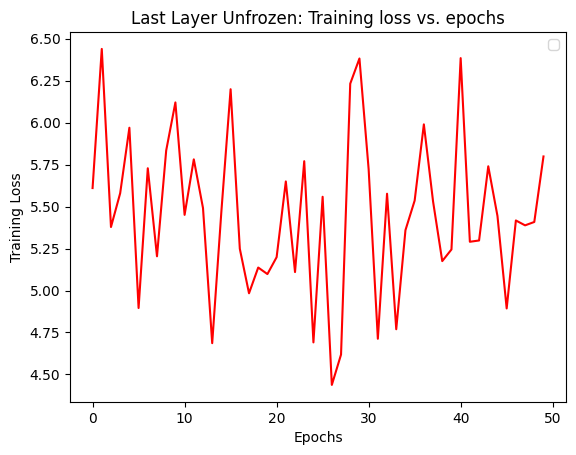

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


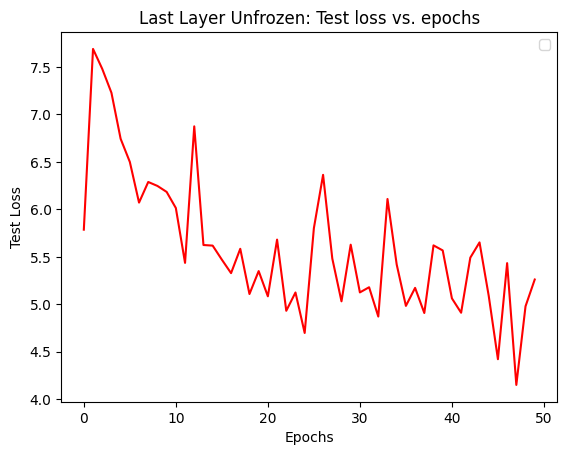

[5.6104, 6.4394, 5.3785, 5.5799, 5.9699, 4.8958, 5.7284, 5.2039, 5.8342, 6.1206, 5.4508, 5.7816, 5.4914, 4.6863, 5.4731, 6.1993, 5.2489, 4.9836, 5.137, 5.098, 5.1985, 5.6499, 5.11, 5.7705, 4.6909, 5.5586, 4.4376, 4.6184, 6.2323, 6.3824, 5.7226, 4.7126, 5.5767, 4.7693, 5.3595, 5.5358, 5.9899, 5.531, 5.1753, 5.2446, 6.3846, 5.2905, 5.2981, 5.7401, 5.444, 4.8932, 5.4174, 5.3883, 5.4084, 5.7988]
[5.7862, 7.6906, 7.4807, 7.2288, 6.7438, 6.4998, 6.0715, 6.2887, 6.247, 6.184, 6.0144, 5.4364, 6.8749, 5.6246, 5.6183, 5.4703, 5.3283, 5.5847, 5.1083, 5.3498, 5.0841, 5.6815, 4.9316, 5.1244, 4.6981, 5.802, 6.3639, 5.4827, 5.0312, 5.6282, 5.1253, 5.1796, 4.8707, 6.1094, 5.419, 4.9832, 5.1731, 4.9082, 5.6208, 5.5676, 5.0626, 4.9111, 5.4916, 5.6521, 5.0892, 4.4214, 5.4337, 4.1505, 4.9792, 5.261]


In [35]:
import matplotlib.pyplot as plt

train_losses = []

for log in trainer_sentences.state.log_history:
    if 'loss' in log:
        train_losses.append(log['loss'])

# print(train_losses)

plt.title("Last Layer Unfrozen: Training loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.plot(range(len(train_losses)), train_losses, color ="red")
plt.legend()
plt.show()

test_losses = []

for log in test_sentences.state.log_history:
    if 'loss' in log:
        test_losses.append(log['loss'])

plt.title("Last Layer Unfrozen: Test loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Test Loss")
plt.plot(range(len(test_losses)), test_losses, color ="red")
plt.legend()
plt.show()

print(train_losses)
print(test_losses)